In [230]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from dataloader.dataloader import DataLoader
from preprocessing.clustering_segmentation import ClusteringSegmentation
from preprocessing.edge_detection import EdgeDetection
from preprocessing.image_restoration import ImageRestorer
from preprocessing.preproccessing import ImagePreprocessor
from preprocessing.region_segmentation import RegionBasedSegmentation
from preprocessing.threshold_segmentation import ThresholdSegmentation
from feature_extraction.feature_extraction import FeatureExtractor
from feature_selection.feature_selection import FeatureSelector
from model_selection.model_selection import ModelSelection
from performance_analysis.performance_analysis import PerformanceAnalysis
from illumination_preprocessing.illumination_preprocessing import IlluminationPreprocessing

import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Loading

In [231]:
dataloader = DataLoader(Path('./data'))

# Load Data from files
x_train, y_train, x_test, y_test, x_val, y_val = dataloader.load_data(data_augmentation=False)

Image data\men\2\2_men (107).JPG is corrupted
Image data\men\2\2_men (108).JPG is corrupted
Image data\men\3\3_men (140).JPG is corrupted
Image data\men\3\3_men (141).JPG is corrupted
Image data\men\4\4_men (5).JPG is corrupted
Image data\men\4\4_men (6).JPG is corrupted


In [233]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")

x_train shape: (1445, 320, 320, 3)
y_train shape: (1445,)
x_test shape: (188, 320, 320, 3)
y_test shape: (188,)
x_val shape: (188, 320, 320, 3)
y_val shape: (188,)


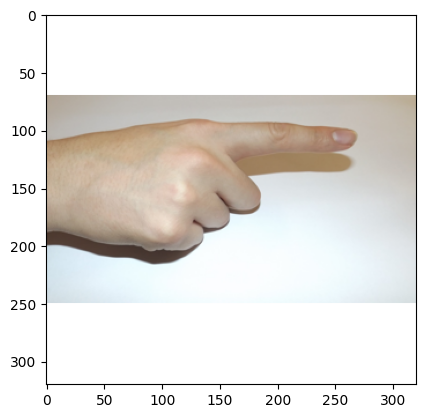

y_train[20]: 1


In [247]:
index = 20
plt.imshow(x_train[index])
plt.show()
print(f"y_train[{index}]: {y_train[index]}") 

## Preprocessing

In [238]:
illumination_processing = IlluminationPreprocessing()
illuminated_list = illumination_processing.process_images_loops(x_train)
illuminated_train = [t[0] for t in illuminated_list]
illuminated_train_mask = [t[1] for t in illuminated_list]

illuminated_list_val = illumination_processing.process_images_loops(x_val)
illuminated_val = [t[0] for t in illuminated_list_val]
illuminated_val_mask = [t[1] for t in illuminated_list_val]

illuminated_train shape: (1445, 320, 320)
illuminated_train_mask shape: (1445, 320, 320)
illuminated_val shape: (188, 320, 320)
illuminated_val_mask shape: (188, 320, 320)


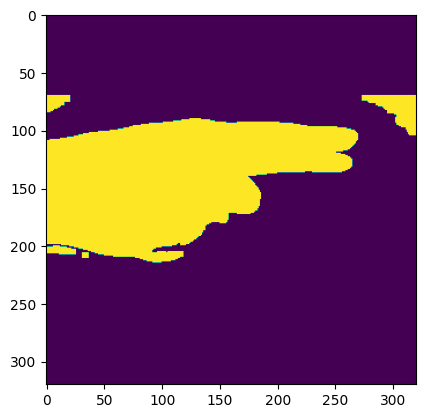

In [ ]:
illuminated_train = np.array(illuminated_train)
illuminated_train_mask = np.array(illuminated_train_mask)
illuminated_val = np.array(illuminated_val)
illuminated_val_mask = np.array(illuminated_val_mask)

print(f"illuminated_train shape: {illuminated_train.shape}")
print(f"illuminated_train_mask shape: {illuminated_train_mask.shape}")
print(f"illuminated_val shape: {illuminated_val.shape}")
print(f"illuminated_val_mask shape: {illuminated_val_mask.shape}")
plt.imshow(illuminated_train[index])
plt.show()

## Features Extraction And Selection

In [248]:
feature_extractor = FeatureExtractor()
feature_selector = FeatureSelector()

pca_features_train = np.zeros((illuminated_train.shape[0],0))
pca_features_val = np.zeros((illuminated_val.shape[0],0))

In [249]:
print(f"pca features train shape: {pca_features_train.shape}")
print(f"pca features val shape: {pca_features_val.shape}")

pca features train shape: (1445, 0)
pca features val shape: (188, 0)


### Hog Features

In [250]:
hog_features_train = feature_extractor.extract_hog_features(illuminated_train_mask)
hog_features_val = feature_extractor.extract_hog_features(illuminated_val_mask)

pca_hog_features_train = feature_selector.extract_pca_features(hog_features_train,load=False, num_pca_components=0.95)
pca_hog_features_val = feature_selector.extract_pca_features(hog_features_val,load=True, num_pca_components=0.95)

pca_features_train = np.concatenate((pca_features_train, pca_hog_features_train), axis=1)
pca_features_val = np.concatenate((pca_features_val, pca_hog_features_val), axis=1)

print(f"extracted_features shape: {hog_features_train.shape}")
print(f"extracted_features_val shape: {hog_features_val.shape}")

print(f"hog pca features train shape: {pca_hog_features_train.shape}")
print(f"hog pca features val shape: {pca_hog_features_val.shape}")

print(f"pca features train shape: {pca_features_train.shape}")
print(f"pca features val shape: {pca_features_val.shape}")

Creating new PCA model...


### LBP Features

In [ ]:
lbp_features_train = feature_extractor.extract_lbp_features(illuminated_train_mask)
lbp_features_val = feature_extractor.extract_lbp_features(illuminated_val_mask)

pca_lbp_features_train = feature_selector.extract_pca_features(lbp_features_train,load=False, num_pca_components=0.95)
pca_lbp_features_val = feature_selector.extract_pca_features(lbp_features_val,load=True, num_pca_components=0.95)

pca_features_train = np.concatenate((pca_features_train, pca_lbp_features_train), axis=1)
pca_features_val = np.concatenate((pca_features_val, pca_lbp_features_val), axis=1)

print(f"extracted_features shape: {lbp_features_train.shape}")
print(f"extracted_features_val shape: {lbp_features_val.shape}")

print(f"lbp pca features train shape: {pca_lbp_features_train.shape}")
print(f"lbp pca features val shape: {pca_lbp_features_val.shape}")

print(f"pca features train shape: {pca_features_train.shape}")
print(f"pca features val shape: {pca_features_val.shape}")

### SIFT Features

In [ ]:
sift_features_train = feature_extractor.extract_sift_features(illuminated_train_mask)
sift_features_val = feature_extractor.extract_sift_features(illuminated_val_mask)

pca_sift_features_train = feature_selector.extract_pca_features(sift_features_train,load=False, num_pca_components=0.95)
pca_sift_features_val = feature_selector.extract_pca_features(sift_features_val,load=True, num_pca_components=0.95)

pca_features_train = np.concatenate((pca_features_train, pca_sift_features_train), axis=1)
pca_features_val = np.concatenate((pca_features_val, pca_sift_features_val), axis=1)

print(f"extracted_features shape: {sift_features_train.shape}")
print(f"extracted_features_val shape: {sift_features_val.shape}")

print(f"sift pca features train shape: {pca_sift_features_train.shape}")
print(f"sift pca features val shape: {pca_sift_features_val.shape}")

print(f"pca features train shape: {pca_features_train.shape}")
print(f"pca features val shape: {pca_features_val.shape}")

### DAISY Features

In [ ]:
daisy_features_train = feature_extractor.extract_daisy_features(illuminated_train_mask)
daisy_features_val = feature_extractor.extract_daisy_features(illuminated_val_mask)

pca_daisy_features_train = feature_selector.extract_pca_features(daisy_features_train,load=False, num_pca_components=0.95)
pca_daisy_features_val = feature_selector.extract_pca_features(daisy_features_val,load=True, num_pca_components=0.95)

pca_features_train = np.concatenate((pca_features_train, pca_daisy_features_train), axis=1)
pca_features_val = np.concatenate((pca_features_val, pca_daisy_features_val), axis=1)

print(f"extracted_features shape: {daisy_features_train.shape}")
print(f"extracted_features_val shape: {daisy_features_val.shape}")

print(f"daisy pca features train shape: {pca_daisy_features_train.shape}")
print(f"daisy pca features val shape: {pca_daisy_features_val.shape}")

print(f"pca features train shape: {pca_features_train.shape}")
print(f"pca features val shape: {pca_features_val.shape}")

### Fourier Descriptor Features

In [ ]:
fd_features_train = feature_extractor.extract_fourier_descriptor_features(illuminated_train_mask)
fd_features_val = feature_extractor.extract_fourier_descriptor_features(illuminated_val_mask)

pca_fd_features_train = feature_selector.extract_pca_features(fd_features_train,load=False, num_pca_components=0.95)
pca_fd_features_val = feature_selector.extract_pca_features(fd_features_val,load=True, num_pca_components=0.95)

pca_features_train = np.concatenate((pca_features_train, pca_fd_features_train), axis=1)
pca_features_val = np.concatenate((pca_features_val, pca_fd_features_val), axis=1)

print(f"extracted_features shape: {fd_features_train.shape}")
print(f"extracted_features_val shape: {fd_features_val.shape}")

print(f"fd pca features train shape: {pca_fd_features_train.shape}")
print(f"fd pca features val shape: {pca_fd_features_val.shape}")

print(f"pca features train shape: {pca_features_train.shape}")
print(f"pca features val shape: {pca_features_val.shape}")

### ORB Features

In [ ]:
orb_features_train = feature_extractor.extract_orb_features(illuminated_train_mask)
orb_features_val = feature_extractor.extract_orb_features(illuminated_val_mask)

pca_orb_features_train = feature_selector.extract_pca_features(orb_features_train,load=False, num_pca_components=0.95)
pca_orb_features_val = feature_selector.extract_pca_features(orb_features_val,load=True, num_pca_components=0.95)

pca_features_train = np.concatenate((pca_features_train, pca_orb_features_train), axis=1)
pca_features_val = np.concatenate((pca_features_val, pca_orb_features_val), axis=1)

print(f"extracted_features shape: {orb_features_train.shape}")
print(f"extracted_features_val shape: {orb_features_val.shape}")

print(f"orb pca features train shape: {pca_orb_features_train.shape}")
print(f"orb pca features val shape: {pca_orb_features_val.shape}")

print(f"pca features train shape: {pca_features_train.shape}")
print(f"pca features val shape: {pca_features_val.shape}")

### RI HOG Features

In [229]:
ri_hog_features_train = feature_extractor.RI_HOG(illuminated_train_mask)
ri_hog_features_val = feature_extractor.RI_HOG(illuminated_val_mask)

pca_ri_hog_features_train = feature_selector.extract_pca_features(ri_hog_features_train,load=False, num_pca_components=0.95)
pca_ri_hog_features_val = feature_selector.extract_pca_features(ri_hog_features_val,load=True, num_pca_components=0.95)

pca_features_train = np.concatenate((pca_features_train, pca_ri_hog_features_train), axis=1)
pca_features_val = np.concatenate((pca_features_val, pca_ri_hog_features_val), axis=1)

print(f"extracted_features shape: {ri_hog_features_train.shape}")
print(f"extracted_features_val shape: {ri_hog_features_val.shape}")

print(f"ri_hog pca features train shape: {pca_ri_hog_features_train.shape}")
print(f"ri_hog pca features val shape: {pca_ri_hog_features_val.shape}")

print(f"pca features train shape: {pca_features_train.shape}")
print(f"pca features val shape: {pca_features_val.shape}")

AxisError: axis 1 is out of bounds for array of dimension 1

### Hu moments Features

In [ ]:
hu_moment_features_train = feature_extractor.extract_hu_moments_features(illuminated_train_mask)
hu_moment_features_val = feature_extractor.extract_hu_moments_features(illuminated_val_mask)

pca_hu_moment_features_train = feature_selector.extract_pca_features(hu_moment_features_train,load=False, num_pca_components=0.95)
pca_hu_moment_features_val = feature_selector.extract_pca_features(hu_moment_features_val,load=True, num_pca_components=0.95)

pca_features_train = np.concatenate((pca_features_train, pca_hu_moment_features_train), axis=1)
pca_features_val = np.concatenate((pca_features_val, pca_hu_moment_features_val), axis=1)

print(f"extracted_features shape: {hu_moment_features_train.shape}")
print(f"extracted_features_val shape: {hu_moment_features_val.shape}")

print(f"hu_moment pca features train shape: {pca_hu_moment_features_train.shape}")
print(f"hu_moment pca features val shape: {pca_hu_moment_features_val.shape}")

print(f"pca features train shape: {pca_features_train.shape}")
print(f"pca features val shape: {pca_features_val.shape}")

### Convex Hull Features

In [ ]:
convex_hull_features_train = feature_extractor.extract_convex_hull_features(illuminated_train_mask)
convex_hull_features_val = feature_extractor.extract_convex_hull_features(illuminated_val_mask)

pca_convex_hull_features_train = feature_selector.extract_pca_features(convex_hull_features_train,load=False, num_pca_components=0.95)
pca_convex_hull_features_val = feature_selector.extract_pca_features(convex_hull_features_val,load=True, num_pca_components=0.95)

pca_features_train = np.concatenate((pca_features_train, pca_convex_hull_features_train), axis=1)
pca_features_val = np.concatenate((pca_features_val, pca_convex_hull_features_val), axis=1)

print(f"extracted_features shape: {convex_hull_features_train.shape}")
print(f"extracted_features_val shape: {convex_hull_features_val.shape}")

print(f"convex_hull pca features train shape: {pca_convex_hull_features_train.shape}")
print(f"convex_hull pca features val shape: {pca_convex_hull_features_val.shape}")

print(f"pca features train shape: {pca_features_train.shape}")
print(f"pca features val shape: {pca_features_val.shape}")

### Eliiptical fourier descriptors features

In [ ]:
elliptical_fd_features_train = feature_extractor.elliptical_fourier_descriptors(illuminated_train_mask)
elliptical_fd_features_val = feature_extractor.elliptical_fourier_descriptors(illuminated_val_mask)

pca_elliptic_fd_features_train = feature_selector.extract_pca_features(elliptic_fd_features_train,load=False, num_pca_components=0.95)
pca_elliptic_fd_features_val = feature_selector.extract_pca_features(elliptic_fd_features_val,load=True, num_pca_components=0.95)

pca_features_train = np.concatenate((pca_features_train, pca_elliptic_fd_features_train), axis=1)
pca_features_val = np.concatenate((pca_features_val, pca_elliptic_fd_features_val), axis=1)

print(f"extracted_features shape: {elliptic_fd_features_train.shape}")
print(f"extracted_features_val shape: {elliptic_fd_features_val.shape}")

print(f"elliptic_fd pca features train shape: {pca_elliptic_fd_features_train.shape}")
print(f"elliptic_fd pca features val shape: {pca_elliptic_fd_features_val.shape}")

print(f"pca features train shape: {pca_features_train.shape}")
print(f"pca features val shape: {pca_features_val.shape}")

## PCA

### Normalizing the PCA extracted features

In [ ]:
# PCA FEATURES

pca_features_train = feature_selector.extract_pca_features(extracted_features, load=False, num_pca_components=0.85)
pca_features_val = feature_selector.extract_pca_features(extracted_features_val, load=True, num_pca_components=0.85)

print(f"pca_features shape: {pca_features.shape}")
print(f"pca_features_val shape: {pca_features_val.shape}")

In [ ]:
extracted_features_train_mean = pca_features_train.mean(axis=0)
extracted_features_train_std = pca_features_train.std(axis=0)

In [ ]:
pca_features_train = (pca_features_train - extracted_features_train_mean) /extracted_features_train_std
pca_features_val = (pca_features_val - extracted_features_train_mean) /extracted_features_train_std

extracted_features_train_mean = pca_features_train.mean(axis=0)
extracted_features_train_std = pca_features_train.std(axis=0)

## Models

In [ ]:
model_selection = ModelSelection(pca_features_train, y_train, pca_features_val, y_val)

svm, pred_train, pred_val = model_selection.SVM()
performance_analysis = PerformanceAnalysis('SVM Train', pred_train, y_train)
performance_analysis.calculate_performance_metrics()
performance_analysis = PerformanceAnalysis('SVM Val', pred_val, y_val)
performance_analysis.calculate_performance_metrics()


knn, pred_train, pred_val = model_selection.KNN()
performance_analysis = PerformanceAnalysis('KNN Train', pred_train, y_train)
performance_analysis.calculate_performance_metrics()
performance_analysis = PerformanceAnalysis('KNN Val', pred_val, y_val)
performance_analysis.calculate_performance_metrics()

ensemble, pred_train, pred_val = model_selection.Ensemble()
performance_analysis = PerformanceAnalysis('Ensemble Train', pred_train, y_train)
performance_analysis.calculate_performance_metrics()
performance_analysis = PerformanceAnalysis('Ensemble Val', pred_val, y_val)
performance_analysis.calculate_performance_metrics()


adaboost, pred_train, pred_val = model_selection.AdaBoost()
performance_analysis = PerformanceAnalysis('AdaBoost Train', pred_train, y_train)
performance_analysis.calculate_performance_metrics()
performance_analysis = PerformanceAnalysis('AdaBoost Val', pred_val, y_val)
performance_analysis.calculate_performance_metrics()

In [ ]:
ann, pred_train, pred_val = model_selection.ANN(input_dim=pca_features_train.shape[1], 
                                                output_dim=6)
performance_analysis = PerformanceAnalysis('ANN Train', pred_train, y_train)
performance_analysis.calculate_performance_metrics()
performance_analysis = PerformanceAnalysis('ANN Val', pred_val, y_val)
performance_analysis.calculate_performance_metrics()